# PANOPTES Data Explorer

The tools in the `panoptes.utils.data` modules are designed to help you easily find and start using PANOPTES data.  This is the same software the powers https://panoptes-data.net

The module primarly offers an interface that allows you to search and find any observation metadata from the PANOPTES network. The module also offers convenient methods for downloading the raw data.

In [1]:
# Necessary imports
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroplan.observer import Observer
from astroplan.plots import plot_airmass

from panoptes.pipeline.utils import metadata
from panoptes.pipeline.utils.gcp.bigquery import get_bq_clients

import seaborn as sb
import pandas as pd
from IPython.display import Image

# Update our catalog for moon position (see below).
from astroplan import download_IERS_A
download_IERS_A()

sb.set_theme()  # reset to default
sb.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

# Setup a BigQuery client.
bq_client, bqstorage_client = get_bq_clients()

## Getting Started

The primary search function, `metadata.search_observations`, allows you to query the PANOPTES data by coordinate location, with optional filters for things such as `radius`, `unit_id`, `min_num_images`, etc.

This is simply a convenience function to download and filter CSV file that is generated when new observations are added to the PANOPTES network.

In [2]:
# Show the search options.
metadata.search_observations?

Signature:
metadata.search_observations(
    coords=None,
    unit_id=None,
    start_date=None,
    end_date=None,
    ra=None,
    dec=None,
    radius=10,
    status='matched',
    min_num_images=1,
    source_url='https://storage.googleapis.com/panoptes-exp.appspot.com/observations.csv',
    source=None,
)
Docstring:
Search PANOPTES observations.

Either a `coords` or `ra` and `dec` must be specified for search to work.

>>> from astropy.coordinates import SkyCoord
>>> from panoptes.utils.data import search_observations
>>> coords = SkyCoord.from_name('Andromeda Galaxy')
>>> start_date = '2019-01-01'
>>> end_date = '2019-12-31'
>>> search_results = search_observations(coords=coords, min_num_images=10, start_date=start_date, end_date=end_date)
>>> # The result is a DataFrame you can further work with.
>>> image_count = search_results.groupby(['unit_id', 'field_name']).num_images.sum()
>>> image_count
unit_id  field_name
PAN001   Andromeda Galaxy     378
         HAT-P-19            

### Search for observations

Let's perform the same search that's in the example above, namely looking for all observations within 10° of the Andromeda Galaxy. 

However, instead of just December 2019 we are going to look at all data we have* by not specifying a `start_date` or `end_date`.

We will also specify that we only want observations that have a minium of 10 images in the sequence.

*The careful reader of docstrings will note that the `start_date` will default to `2018-01-01` when not specified.  Earlier data is available if dates before that are given. The data from 2016 and 2017 is only from `PAN001` and there were significant tracking errors for most observations.

In [3]:
# Get from existing coords
target_coords = SkyCoord.from_name('Andromeda Galaxy')

observations_df = metadata.search_observations(
    coords=target_coords, 
    min_num_images=10, 
    radius=10
)

We group up these observations by the PANOPTES unit that took them and the field name that was assigned by the unit operator and look at the total exposure time for that particular "target".

> Note: The "target", or `field_name` column below, is user-editable, so there may be some slight overlap, e.g. "Hat-P-19" and "HAT-P-19b".

In [4]:
# Group by unit and field and sum the metrics
field_sums = observations_df.groupby(['unit_id', 'field_name']).sum().reset_index()
field_sums

,unit_id,field_name,ra,dec,exptime,iso,num_images,total_minutes_exptime
0,PAN001,Andromeda Galaxy,162.791818,616.626258,1802.1,1500,378.0,756.00
1,PAN001,HAT-P-16,177.496965,759.741035,2162.7,1800,975.0,1950.00
2,PAN001,HAT-P-19,342.981938,1291.956877,4624.9,3700,1504.0,3082.00
3,PAN001,TESS_SEC17_CAM02,823.578603,11913.343655,21710.8,24800,10565.0,14739.50
4,PAN006,HAT-P-19,106.758235,241.452655,841.8,700,289.0,578.00
5,PAN006,HAT-P-19 b,27.053754,72.855889,240.4,200,26.0,52.00
6,PAN012,Andromeda Galaxy,43.272701,165.448216,479.9,400,55.0,110.00
7,PAN012,HAT-P-16 b,18.879781,84.730792,239.8,200,268.0,536.00
8,PAN012,TESS_SEC17_CAM02,102.444940,1495.348409,3720.5,3100,1451.0,2903.34
9,PAN018,TESS_SEC17_CAM02,16.475524,244.053126,597.0,500,244.0,484.66


You can see, for instance, that as of this writing there are about 15,000 minutes of exposure time for `TESS_SEC17_CAM02` from `PAN001` and almost 3000 minutes from `PAN012`.

We can also break this down by unit and camera (observations are camera specific for processing purposes).

In [5]:
columns = ['num_images', 'total_minutes_exptime']
observations_df.groupby(['unit_id', 'camera_id'])[columns].sum()

num_images  total_minutes_exptime
unit_id camera_id                                   
PAN001  14d3bd         6762.0               10398.50
        ee04d1         6660.0               10129.00
PAN006  6575fc          164.0                 328.00
        7bab97          151.0                 302.00
PAN012  358d0f         1389.0                2778.67
        95cdbc          385.0                 770.67
PAN018  1e457a          167.0                 330.66
        54d3e9           77.0                 154.00

### Filter to needs

The total exposures times listed above are split across a large number of observations and we want to find one observation to process, so instead of grouping, let's look at all the observations in `observations_df`.

This could be filtered in any number of ways, such as if you wanted a specific `unit_id` or `camera_id`, etc.   

For our purposes we are just going to look at those images that have the highest total exposure time.

In [6]:
# Look at all returned observations by total minutes in observation
observations_df.sort_values('total_minutes_exptime', ascending=False).head(20)

,sequence_id,unit_id,camera_id,ra,dec,exptime,field_name,iso,num_images,software_version,status,time,total_minutes_exptime
3960,PAN012_358d0f_20190821T054434,PAN012,358d0f,9.309703,42.266753,119.9,HAT-P-16 b,100,134.0,POCSv0.6.2,matched,2019-08-21 05:44:34+00:00,268.0
3959,PAN012_95cdbc_20190821T054434,PAN012,95cdbc,9.570078,42.464039,119.9,HAT-P-16 b,100,134.0,POCSv0.6.2,matched,2019-08-21 05:44:34+00:00,268.0
4503,PAN018_1e457a_20191021T125706,PAN018,1e457a,3.287860,48.174383,119.0,TESS_SEC17_CAM02,100,90.0,POCSv0.6.2,matched,2019-10-21 12:57:06+00:00,178.2
2108,PAN001_14d3bd_20181108T050226,PAN001,14d3bd,9.581777,42.471700,120.0,HAT-P-16,100,83.0,POCSv0.6.2,matched,2018-11-08 05:02:26+00:00,166.0
2151,PAN001_ee04d1_20181112T050023,PAN001,ee04d1,8.573878,35.506061,120.3,HAT-P-19,100,80.0,POCSv0.6.2,matched,2018-11-12 05:00:23+00:00,160.0
2109,PAN001_ee04d1_20181108T050226,PAN001,ee04d1,8.601876,43.281457,120.3,HAT-P-16,100,78.0,POCSv0.6.2,matched,2018-11-08 05:02:26+00:00,156.0
2117,PAN001_14d3bd_20181109T052947,PAN001,14d3bd,9.554260,42.466606,120.0,HAT-P-16,100,76.0,POCSv0.6.2,matched,2018-11-09 05:29:47+00:00,152.0
4955,PAN012_95cdbc_20200123T024300,PAN012,95cdbc,3.286532,48.228431,120.1,TESS_SEC17_CAM02,100,70.0,POCSv0.6.2,matched,2020-01-23 02:43:00+00:00,140.0
4206,PAN001_14d3bd_20190913T080023,PAN001,14d3bd,3.287077,48.230305,120.0,TESS_SEC17_CAM02,100,70.0,POCSv0.6.2,matched,2019-09-13 08:00:23+00:00,140.0
4366,PAN012_358d0f_20191005T041329,PAN012,358d0f,2.977367,48.024722,120.0,TESS_SEC17_CAM02,100,70.0,POCSv0.6.2,matched,2019-10-05 04:13:29+00:00,140.0


Looks like `PAN012` got a nice long sequence of images in August for the "HAT-P-16 b" `field_name` with the `sequence_id` of `PAN012_358d0f_20190821T054434`. Let's use that.

We can now use the `metadata.get_metadata` to search for the individual image data.

In [7]:
metadata.get_metadata?

Signature: metadata.get_metadata(sequence_id=None, fields=None, show_progress=False)
Docstring:
Access PANOPTES data from the network.

This function is capable of searching for metadata of PANOPTES observations.

Currently this only supports searching at the observation level, and
so the function is a thin-wrapper around the `get_observation_metadata`.

>>> from panoptes.utils.data import get_metadata

>>> # Get all image metadata for the observation.
>>> sequence_id = 'PAN001_14d3bd_20170405T100854'
>>> observation_df = get_metadata(sequence_id=sequence_id)

>>> type(observation_df)
<class 'pandas.core.frame.DataFrame'>

>>> print('Total exptime: ', observation_df.image_exptime.sum())
Total exptime:  7200.0

>>> # It's also possible to request certain fields
>>> airmass_df = get_metadata(sequence_id=sequence_id, fields=['image_airmass'])
>>> airmass_df.head()
   image_airmass                    sequence_id                      time
0       1.174331  PAN001_14d3bd_20170405T100854 2017

### Get observation metadata

We want to look at some of the metadata and images to decide if this is a good observation. 

Start by selecting a `sequence_id` from the table above. Here we have selected the top observation.

In [8]:
sequence_id = 'PAN012_95cdbc_20190821T054434'

Now we simply query the by `sequence_id`.

In [9]:
images_df = metadata.get_metadata(sequence_id=sequence_id)
images_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 0 to 133
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   bucket_path                134 non-null    string             
 1   camera_blue_balance        134 non-null    float64            
 2   camera_circconf            134 non-null    float64            
 3   camera_colortemp           134 non-null    int64              
 4   camera_iso                 134 non-null    Int64              
 5   camera_lens_serial_number  134 non-null    string             
 6   camera_measured_b          134 non-null    Int64              
 7   camera_measured_ev         134 non-null    float64            
 8   camera_measured_ev2        134 non-null    float64            
 9   camera_measured_g1         134 non-null    Int64              
 10  camera_measured_g2         134 non-null    Int64              
 11  camera

### Examine observation data

The image metadata includes information from the EXIF data of the image in the `camera_<column>` fields. 

The `image_<COLUMN>` and `mount_<COLUMN>` columns contain information from POCS about the image.

In [10]:
# Examine first record
images_df.iloc[0]

bucket_path                  PAN012/95cdbc/20190821T054434/20190821T054827....
camera_blue_balance                                                    1.47754
camera_circconf                                                          0.019
camera_colortemp                                                          5266
camera_iso                                                                 100
camera_lens_serial_number                                            HC0205347
camera_measured_b                                                          688
camera_measured_ev                                                       -3.62
camera_measured_ev2                                                     -3.625
camera_measured_g1                                                        1024
camera_measured_g2                                                        1024
camera_measured_r                                                          506
camera_red_balance                                  

We can do a quick spot on the quality of each image by looking at the changing color temperature of the images. While these can vary considerably depending on the viewing conditions, any major deviations from the the other images should stand out.

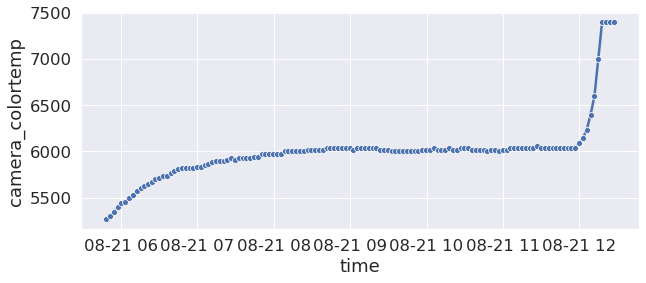

In [11]:
sb.set_style('darkgrid')
ax = sb.lineplot(data=images_df, 
                 x='time', 
                 y='camera_colortemp', 
                 marker='o',
                )

ax.figure.set_size_inches(10, 4)

Here it looks like the last couple of frames have a significant change, so we look at the jpg for the last images by using the `public_url`.

Note that the `public_url` is for the FITS file, but there should exists a JPG version of every FITS file.

In [12]:
# Negative index starts from end.
frame_number = -1

In [13]:
jpg_url = images_df.iloc[frame_number].public_url.replace('.fits.fz', '.jpg')

Image(url=jpg_url, width=800)

Looks like the sun is just coming up, which our algorithm can handle, but let's check by plotting the airmass along with the sunrise/sunset shading via the `plot_airmass` function from [astroplan](https://astroplan.readthedocs.io/en/latest/tutorials/plots.html).

In [14]:
# Get the first record for easy access to site info.
first_image = images_df.iloc[0]

In [15]:
# Make an "observer" from the image location.
observer = Observer(latitude=first_image.site_latitude, 
                    longitude=first_image.site_longitude, 
                    elevation=first_image.site_elevation * u.meter)

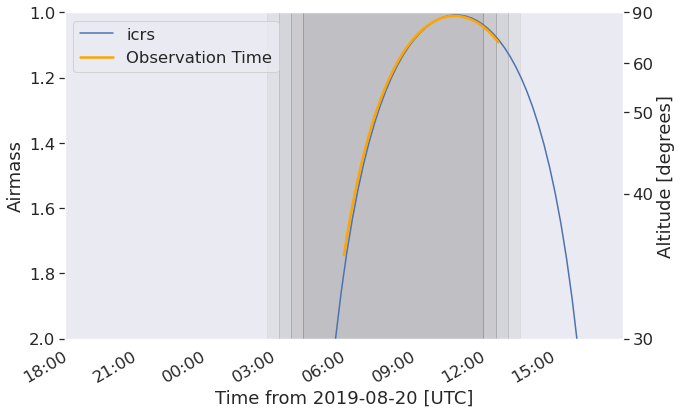

In [16]:
sb.set_style('dark')

ax = plot_airmass(target_coords, observer, 
                  first_image.time, 
                  brightness_shading=True, 
                  altitude_yaxis=True,
                  max_airmass=2.0
                 )

sb.lineplot(data=images_df,
            x='time',
            y='image_airmass',
            ax=ax,
            color='orange',
            label='Observation Time',
           )

ax.figure.set_size_inches(10, 6);

Suspicions confirmed, we won't worry about removing individual images because of obstructions or anything else.

### Gather images

Now that we have a `sequence_id` and have checked any suspicious images, we will go ahead and download the FITS files.

The `public_url` contains a download link that we can use with `wget`/`curl` or simply by entering in a browser.  Here we use the convenience function `metadata.download_images` to download the files one by one.

Note that using the google `gsutil` can be massively more efficient.  If you are trying to get a lot of data let the PANOPTES team now and we can help provide the best solution.

In [17]:
# Get list of public urls
download_list = images_df.public_url.dropna().to_list()

In [18]:
base_dir = '/home/jupyter/data'
output_dir = f'{base_dir}/{sequence_id}'

In [19]:
# Download and unpack FITS files.
fits_files = metadata.download_images(download_list, output_dir)

In [20]:
# Record local file location in dataframe.
images_df['local_file'] = fits_files

### Save dataframe locally

Now that we have all our information in the `images_df` file we can save locally so we don't need to go through the above again.

Since it's a fairly small dataframe, we will just save to a csv file in our same output directory.

In [21]:
images_df_path = f'{output_dir}/images-metadata.csv'

In [22]:
images_df.to_csv(images_df_path, index=False)

In [24]:
ls -lh {images_df_path}

-rw-r--r-- 1 root root 78K Nov  1 17:08 /home/jupyter/data/PAN012_95cdbc_20190821T054434/images-metadata.csv


### Next steps

Now that we have an observation we are interested and all the necessary data saved locally, we will move on to catalog matching and Postage Stamp Cube (PSC) creation.

Check out the [Stamp Extraction](Stamp%20Extraction.ipynb) notebook for more!